In [1]:
import numpy as np
import soundfile as sf
import os 
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import torch

from Lab3 import lab3_proto as proto3
from Lab3 import lab3_tools as tools3
from Lab2 import lab2_proto as proto2
from Lab2 import lab2_tools as tools2
from Lab1 import lab1_proto as proto1
from Lab1 import lab1_tools as tools1
from Lab2.prondict import prondict 

# Preparing the Data for DNN Training 

## 4.1 Target Class Definition

In [2]:
phoneHMMs = np.load("./Lab2/lab2_models_all.npz", allow_pickle=True)["phoneHMMs"].item()
phones = sorted(phoneHMMs.keys())
nstates = {phone: phoneHMMs[phone]['means'].shape[0] for phone in phones}
stateList = [ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]
print(stateList)
print()
print(stateList.index('ay_2'))

['ah_0', 'ah_1', 'ah_2', 'ao_0', 'ao_1', 'ao_2', 'ay_0', 'ay_1', 'ay_2', 'eh_0', 'eh_1', 'eh_2', 'ey_0', 'ey_1', 'ey_2', 'f_0', 'f_1', 'f_2', 'ih_0', 'ih_1', 'ih_2', 'iy_0', 'iy_1', 'iy_2', 'k_0', 'k_1', 'k_2', 'n_0', 'n_1', 'n_2', 'ow_0', 'ow_1', 'ow_2', 'r_0', 'r_1', 'r_2', 's_0', 's_1', 's_2', 'sil_0', 'sil_1', 'sil_2', 'sp_0', 't_0', 't_1', 't_2', 'th_0', 'th_1', 'th_2', 'uw_0', 'uw_1', 'uw_2', 'v_0', 'v_1', 'v_2', 'w_0', 'w_1', 'w_2', 'z_0', 'z_1', 'z_2']

8


## 4.2 Forced Alignment

In [3]:
# the dataset is not on the github due to the copyright
filename = './../tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'
samples, samplingrate = tools3.loadAudio(filename)
lmfcc = proto1.mfcc(samples)

wordTrans = list(tools3.path2info(filename)[2])  # Transcription using words
print(f"wordTrans: {wordTrans}")

phoneTrans = proto3.words2phones(wordTrans, prondict) # Transcription using phonemes
print(f"phoneTrans: {phoneTrans}")

utteranceHMM = proto2.concatHMMs(phoneHMMs, phoneTrans)
stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]  # Transcription using states
print(f"stateTrans[10]: {stateTrans[10]}")

obsloglik = tools2.log_multivariate_normal_density_diag(lmfcc, utteranceHMM["means"], utteranceHMM["covars"])
viterbiLoglik, viterbiPath = proto2.viterbi(obsloglik, np.log(utteranceHMM['startprob'][:-1]), np.log(utteranceHMM['transmat'][:-1, :-1]), forceFinalState=True)

viterbiStateTrans = [stateTrans[state] for state in viterbiPath]

trans = tools3.frames2trans(viterbiStateTrans, outfilename='z43a.lab')

wordTrans: ['z', '4', '3']
phoneTrans: ['sil', 'z', 'iy', 'r', 'ow', 'sp', 'f', 'ao', 'r', 'sp', 'th', 'r', 'iy', 'sp', 'sil']
stateTrans[10]: r_1


/tmp/ipykernel_719280/2984385968.py:17: RuntimeWarning: divide by zero encountered in log
  viterbiLoglik, viterbiPath = proto2.viterbi(obsloglik, np.log(utteranceHMM['startprob'][:-1]), np.log(utteranceHMM['transmat'][:-1, :-1]), forceFinalState=True)


In [4]:
mspec_res = proto1.mspec(samples)

In [5]:
example = np.load("./Lab3/lab3_example.npz", allow_pickle=True)["example"].item()
# Compare each variable with its corresponding value in the example dictionary

print(f"lmfcc: {np.allclose(lmfcc, example['lmfcc'])}")
print(f"Our wordTrans: \n{wordTrans}\nCorrect wordTrans: \n{example['wordTrans']}")
print(f"Our phoneTrans: \n{phoneTrans}\nCorrect phoneTrans: \n{example['phoneTrans']}")
print(f"Our stateTrans: \n{stateTrans}\nCorrect stateTrans: \n{example['stateTrans']}")
print(f"obsloglik: {np.allclose(obsloglik, example['obsloglik'])}")
print(f"viterbiLoglik: {np.allclose(viterbiLoglik, example['viterbiLoglik'])}")
print(f"viterbiPath: {np.allclose(viterbiPath, example['viterbiPath'])}")
print(f"Our viterbiStateTrans: \n{viterbiStateTrans}\nCorrect viterbiStateTrans: \n{example['viterbiStateTrans']}")

lmfcc: True
Our wordTrans: 
['z', '4', '3']
Correct wordTrans: 
['z', '4', '3']
Our phoneTrans: 
['sil', 'z', 'iy', 'r', 'ow', 'sp', 'f', 'ao', 'r', 'sp', 'th', 'r', 'iy', 'sp', 'sil']
Correct phoneTrans: 
['sil', 'z', 'iy', 'r', 'ow', 'sp', 'f', 'ao', 'r', 'sp', 'th', 'r', 'iy', 'sp', 'sil']
Our stateTrans: 
['sil_0', 'sil_1', 'sil_2', 'z_0', 'z_1', 'z_2', 'iy_0', 'iy_1', 'iy_2', 'r_0', 'r_1', 'r_2', 'ow_0', 'ow_1', 'ow_2', 'sp_0', 'f_0', 'f_1', 'f_2', 'ao_0', 'ao_1', 'ao_2', 'r_0', 'r_1', 'r_2', 'sp_0', 'th_0', 'th_1', 'th_2', 'r_0', 'r_1', 'r_2', 'iy_0', 'iy_1', 'iy_2', 'sp_0', 'sil_0', 'sil_1', 'sil_2']
Correct stateTrans: 
['sil_0', 'sil_1', 'sil_2', 'z_0', 'z_1', 'z_2', 'iy_0', 'iy_1', 'iy_2', 'r_0', 'r_1', 'r_2', 'ow_0', 'ow_1', 'ow_2', 'sp_0', 'f_0', 'f_1', 'f_2', 'ao_0', 'ao_1', 'ao_2', 'r_0', 'r_1', 'r_2', 'sp_0', 'th_0', 'th_1', 'th_2', 'r_0', 'r_1', 'r_2', 'iy_0', 'iy_1', 'iy_2', 'sp_0', 'sil_0', 'sil_1', 'sil_2']
obsloglik: True
viterbiLoglik: True
viterbiPath: True
Our vi

## 4.3 Feature Extraction 

In [6]:
def feature_extraction(path):
  data = []

  for root, dirs, files in os.walk(path):
    for file in tqdm(files):
      if file.endswith('.wav'):
        filename = os.path.join(root, file)
        samples, samplingrate = tools3.loadAudio(filename)

        lmfcc = proto1.mfcc(samples) # Features used for HMM & DNN
        mspec_res = proto1.mspec(samples) # Features used for DNN

        wordTrans = list(tools3.path2info(filename))[2]  # Transcription using words
        phoneTrans = proto3.words2phones(wordTrans, prondict) # Transcription using phonemes
        targets = proto3.forcedAlignment(lmfcc, phoneHMMs, phoneTrans) # Align states to each utterance

        # converting targets to indices to save memory
        target_idx = np.array([stateList.index(target) for target in targets])

        data.append({'filename': filename, 'lmfcc': lmfcc,'mspec': mspec_res, 'targets': target_idx})

  return data


In [7]:
print("Extraction features from train data")
trainData = feature_extraction('../tidigits/disc_4.1.1/tidigits/train')
# Save the data to avoid computing it again
np.savez('trainData.npz', trainData=trainData)

print("Extracting features from test data")
testData = feature_extraction('../tidigits/disc_4.2.1/tidigits/test')
np.savez('testData.npz', testData=testData)

Extraction features from train data


0it [00:00, ?it/s]
0it [00:00, ?it/s]
  0%|          | 0/77 [00:00<?, ?it/s]/home/yohan/Documents/Cantique_des_Cantiques/Project/Speach/Speach-Speaker-Recognition/Lab3/lab3_proto.py:49: RuntimeWarning: divide by zero encountered in log
  _, viterbi_path = viterbi(obslogik, np.log(utteranceHMM["startprob"][:-1]), np.log(utteranceHMM["transmat"][:-1, :-1]), forceFinalState=True)
100%|██████████| 77/77 [00:07<00:00, 10.70it/s]
0it [00:00, ?it/s]
100%|██████████| 77/77 [00:06<00:00, 11.01it/s]


Extracting features from test data


0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 77/77 [00:07<00:00, 10.27it/s]
0it [00:00, ?it/s]
100%|██████████| 77/77 [00:07<00:00,  9.72it/s]


## 4.4 Training and Validation Sets

In [7]:
def splitDataByGender(data_dict,gender, train_utterances):
  train_data, val_data = [], []
  for current_speaker in data_dict[gender].keys():
    # if train_data contains 90 or more procent of total gender utterances, remaining data is stored as validation
    if len(train_data) >= train_utterances:
      #print(f"len(train_data): {len(train_data)} > {train_utterances} --> Creating val set instead")
      val_data.extend(data_dict[gender][str(current_speaker)])
    # Otherwise, we keep adding to train data until we achieve 90%
    else:
      #print(f"len(train_data): {len(train_data)} < {train_utterances}")
      train_data.extend(data_dict[gender][str(current_speaker)])
  print(f"train_data: {len(train_data)} \t val_data: {len(val_data)}")
  return train_data, val_data

def splitData(total_data, split=0.1):
  data_by_gender = {"man":{}, "woman": {}}
  print(f"Total_data length = {len(total_data)}")
  for data in total_data:
    gender, speakerID, _, _ = tools3.path2info(data["filename"])  # path2info returns tuple (gender, speakerID, digits, repetition)
    if speakerID not in data_by_gender[gender]:
      data_by_gender[gender][speakerID] = []
    data_by_gender[gender][speakerID].append(data)

  # Calculate total utterances by summing the lengths of each gender's list
  total_male_utterances = sum(len(utterances) for utterances in data_by_gender["man"].values())
  total_female_utterances = sum(len(utterances) for utterances in data_by_gender["woman"].values())

  train_male_utterances = int(total_male_utterances * (1-split))     # compute how many male utterances to achieve 90%
  train_female_utterances = int(total_female_utterances * (1-split)) # compute how many female utterances to achieve 90%
  print(f"total male utterances: {total_male_utterances}\ntrain_male_utterances: {train_male_utterances}")
  print(f"total female utterances: {total_female_utterances}\ntrain_female_utterances: {train_female_utterances}")

  male_train_data, male_val_data = splitDataByGender(data_by_gender, "man", train_male_utterances)
  female_train_data, female_val_data = splitDataByGender(data_by_gender, "woman", train_female_utterances)

  train_data, val_data = [], []
  train_data.extend(male_train_data)
  train_data.extend(female_train_data)
  val_data.extend(male_val_data)
  val_data.extend(female_val_data)

  print(f"train data has {len(train_data)} elements")
  print(f"val data has {len(val_data)} elements")

  return train_data, val_data


In [10]:
train_data_path = "./trainData.npz"
test_data_path = "./testData.npz"
trainData = np.load(train_data_path, allow_pickle=True)["trainData"]
testData = np.load(test_data_path, allow_pickle=True)["testData"]

print(f"trainData has {len(trainData)} elements")
for key in trainData[0].keys():
  print(f"key: {key} - {trainData[0][key]}")


trainData has 8623 elements
key: filename - ../tidigits/disc_4.1.1/tidigits/train/woman/cl/za.wav
key: lmfcc - [[ 103.1708824   -82.31110635   14.29338738 ...  -38.65502294
  -155.95559352  -48.36368006]
 [ 109.42118969  -11.18161627  117.72133428 ...    8.63922846
   -40.50538129   21.4327149 ]
 [ 116.09423861  -46.88554472   25.04088065 ...  -75.15169037
   -16.42606443   67.31586026]
 ...
 [ 203.16342222  109.37593821   16.40208643 ...  -27.98419695
    -7.0104208     4.57830005]
 [ 164.15952204   87.7355812    85.18308825 ...  117.86320303
    15.88054796   27.40947736]
 [ 170.64996493  107.48479268  124.78120348 ...   -5.24549154
    49.41318624   10.30882344]]
key: mspec - [[-0.12084544  1.03020631  0.46282056 ...  2.09551978  2.27765554
   2.41654246]
 [ 2.54187435  3.06084006  3.07138977 ...  2.16677831  1.97251175
   2.2343435 ]
 [ 1.52510378  2.79239405  1.89996556 ...  1.91766317  1.89914442
   2.66109756]
 ...
 [ 4.40261508  3.47242441  2.87425463 ...  1.88805656  1.8249337

## 4.5 Acoustic Context (Dynamic Features)

In [11]:
def add_context(features, context=3):
    """
    Augments the features by adding context frames around each time step in the feature matrix.

    Args:
    features (np.array): The original feature matrix where each row is a time step and columns are features.
    context (int): The number of frames to include from before and after the current frame.

    Returns:
    np.array: An augmented feature matrix including context.
    """
    rows, cols = features.shape
    context_features = np.zeros((rows, cols * (2 * context + 1)))

    for i in range(rows):
        for j in range(-context, context + 1):
            if 0 <= i + j < rows:
                context_features[i, (j + context) * cols: (j + context + 1) * cols] = features[i + j]
            else:
                # Use mirroring for edge cases
                mirrored_index = min(max(0, i + j), rows - 1)
                context_features[i, (j + context) * cols: (j + context + 1) * cols] = features[mirrored_index]

    return context_features

In [12]:
add_context(trainData[0]["lmfcc"])

array([[103.1708824 , -82.31110635,  14.29338738, ...,   5.21621609,
        -62.65111028, -48.97697333],
       [103.1708824 , -82.31110635,  14.29338738, ..., -95.22756163,
         16.2071291 ,  40.90530715],
       [103.1708824 , -82.31110635,  14.29338738, ..., -72.15412933,
        -66.9767564 , -71.81263328],
       ...,
       [153.06616189,  26.72406375,  29.80793612, ...,  -5.24549154,
         49.41318624,  10.30882344],
       [128.26044834,  37.93693872,  99.15316669, ...,  -5.24549154,
         49.41318624,  10.30882344],
       [177.653294  ,  91.29562855,  43.55066378, ...,  -5.24549154,
         49.41318624,  10.30882344]])

In [13]:
trainData, valData = splitData(trainData)


Total_data length = 8623
total male utterances: 4235
train_male_utterances: 3811
total female utterances: 4388
train_female_utterances: 3949
train_data: 3850 	 val_data: 385
train_data: 4003 	 val_data: 385
train data has 7853 elements
val data has 770 elements


In [14]:
# Train
print("Training data:")
N = sum([len(data['targets']) for data in trainData])
D_lmfcc = trainData[0]["lmfcc"].shape[1]
D_mspec = trainData[0]["mspec"].shape[1]
print(f"N: {N}")
print(f"D_lmfcc: {D_lmfcc} \tD_mspec: {D_mspec}")

# Val
print("Validation data:")
N = sum([len(data['targets']) for data in valData])
D_lmfcc = valData[0]["lmfcc"].shape[1]
D_mspec = valData[0]["mspec"].shape[1]
print(f"N: {N}")
print(f"D_lmfcc: {D_lmfcc} \tD_mspec: {D_mspec}")


Training data:
N: 1366280
D_lmfcc: 13 	D_mspec: 40
Validation data:
N: 140777
D_lmfcc: 13 	D_mspec: 40


## 4.6 Feature Standardisation 

In [15]:
def preprocessing(totalData, _num_classes, context=True):
    Ns = [len(data['targets']) for data in totalData]
    N = sum(Ns)
    D_lmfcc = totalData[0]["lmfcc"].shape[1] * (7 if context else 1)
    D_mspec = totalData[0]["mspec"].shape[1]
    X_lmfcc = np.zeros((N, D_lmfcc)).astype("float32")
    X_mspec = np.zeros((N, D_mspec)).astype("float32")
    Y = np.zeros(N, dtype=int)

    startPointer = 0
    for i, data in enumerate(totalData):
        lmfcc = data["lmfcc"]
        if context:
            lmfcc = add_context(lmfcc, context=3)
        X_lmfcc[startPointer: startPointer + Ns[i]] = lmfcc
        X_mspec[startPointer: startPointer + Ns[i]] = data["mspec"]
        Y[startPointer: startPointer + Ns[i]] = data["targets"]
        startPointer += Ns[i]

    Y = F.one_hot(torch.tensor(Y), num_classes=_num_classes)
    return X_lmfcc, X_mspec, Y

# Creating scalers to standardize the data
scalerLMFCC = StandardScaler()
scalerMSPEC = StandardScaler()

# Preprocessing the data
trainLMFCCX, trainMSPECX, trainY = preprocessing(trainData, len(stateList))
valLMFCCX, valMSPECX, valY = preprocessing(valData, len(stateList))
testLMFCCX, testMSPECX, testY = preprocessing(testData, len(stateList))

# Standardizing the data
scalerLMFCC.fit(trainLMFCCX)
trainLMFCCX = scalerLMFCC.transform(trainLMFCCX)
valLMFCCX = scalerLMFCC.transform(valLMFCCX)
testLMFCCX = scalerLMFCC.transform(testLMFCCX)

scalerMSPEC.fit(trainMSPECX)
trainMSPECX = scalerMSPEC.transform(trainMSPECX)
valMSPECX = scalerMSPEC.transform(valMSPECX)
testMSPECX = scalerMSPEC.transform(testMSPECX)

print(f"Preproccsed all data")
print(f"trainLMFCCX: {trainLMFCCX.shape} \t trainMSPECX: {trainMSPECX.shape} \t trainY: {trainY.shape}")
print(f"valLMFCCX: {valLMFCCX.shape} \t valMSPECX: {valMSPECX.shape} \t valY: {valY.shape}")
print(f"testLMFCCX: {testLMFCCX.shape} \t testMSPECX: {testMSPECX.shape} \t testY: {testY.shape}")

Preproccsed all data
trainLMFCCX: (1366280, 91) 	 trainMSPECX: (1366280, 40) 	 trainY: torch.Size([1366280, 61])
valLMFCCX: (140777, 91) 	 valMSPECX: (140777, 40) 	 valY: torch.Size([140777, 61])
testLMFCCX: (1526682, 91) 	 testMSPECX: (1526682, 40) 	 testY: torch.Size([1526682, 61])


# 5 Phoneme Recognition with Deep Neural Networks



In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from datetime import datetime

In [26]:
def FC_ReLU(in_dim: int,
            out_dim: int) -> nn.Sequential:
  """
    Creates a fully connected layer with ReLU activation.

    Parameters:
    - in_dim (int): The number of input features.
    - out_dim (int): The number of output features.

    Returns:
    - nn.Sequential: A sequential container with a linear layer, batch normalization, and ReLU activation.
  """
  return nn.Sequential(
      nn.Linear(in_features=in_dim, out_features=out_dim),
      nn.BatchNorm1d(out_dim),
      nn.ReLU()
  )

def FC_Sigmoid(in_dim: int,
               out_dim: int) -> nn.Sequential:
  """
    Creates a fully connected layer with Sigmoid activation.

    Parameters:
    - in_dim (int): The number of input features.
    - out_dim (int): The number of output features.

    Returns:
    - nn.Sequential: A sequential container with a linear layer, batch normalization, and Sigmoid activation.
  """
  return nn.Sequential(
      nn.Linear(in_features=in_dim, out_features=out_dim),
      nn.BatchNorm1d(out_dim),
      nn.Sigmoid()
  )

In [27]:
# define the neural network architecture
class Net(torch.nn.Module):
  def __init__(self,
               input_dim: int,
               hidden_dims: list[int],
               output_dim: int,
               active_type: str ="ReLU"):
    super().__init__()
    self.input_dim = input_dim
    self.hidden_dims = hidden_dims
    self.output_dim = output_dim
    self.active_type = active_type

    self.create_network()
    self.weight_init()

  def create_network(self) -> None:
    """
      Constructs the neural network architecture.

      This method creates a sequential container with fully connected layers and the specified activation functions.
    """
    modules = []
    input_dim = self.input_dim
    if self.hidden_dims: # Check if hidden_dims is not empty
      for hidden_dim in self.hidden_dims:
        if self.active_type == "ReLU":
          modules.append(FC_ReLU(input_dim, hidden_dim))
        elif self.active_type == "Sigmoid":
          modules.append(FC_Sigmoid(input_dim, hidden_dim))

        input_dim = hidden_dim

    modules.append(nn.Linear(in_features=input_dim, out_features=self.output_dim))

    self.network = nn.Sequential(*modules)
    self.layers = len(self.hidden_dims) + 1

  def weight_init(self) -> None:
    """
      Initializes the weights of the network.

      This method applies He initialization for ReLU activations and Xavier initialization for Sigmoid activations.
    """
    for m in self.modules():
        if isinstance(m, (nn.Linear)):
          if self.active_type == "ReLU":
            # He initialization
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
          elif self.active_type == "Sigmoid":
            # Xavier initalization
            nn.init.xavier_uniform_(m.weight)

  def forward(self,
              X: torch.Tensor) -> torch.Tensor:
    """
      Forward pass through the network.

      Parameters:
      - X (torch.Tensor): Input tensor.

      Returns:
      - torch.Tensor: Output tensor after applying softmax activation.
    """
    output = self.network(X)
    return F.softmax(output, dim=1)

def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

featureType = "lmfcc"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if featureType == "lmfcc":
  # prepare/load the data into tensors
  train_x, val_x, test_x = trainLMFCCX, valLMFCCX, testLMFCCX
else:
  train_x, val_x, test_x = trainMSPECX, valMSPECX, testLMFCCX

train_y, val_y, test_y = trainY.float(), valY.float(), testY.float()

# instantiate the network and print the structure
input_dim = train_x.shape[1]
hidden_dims = [256,256,256]
output_dim = len(stateList) # classes
net = Net(input_dim, hidden_dims, output_dim).to(device)
print(net)
print('number of prameters:', count_parameters(net))

# define your loss criterion (see https://pytorch.org/docs/stable/nn.html#loss-functions)
criterion = torch.nn.CrossEntropyLoss()

# define the optimizer
optimizer = torch.optim.Adam(net.parameters())

batch_size = 128    # they had 256 but said we could lower it to reduce compute

# create the data loaders for training and validation sets
train_dataset = torch.utils.data.TensorDataset(torch.Tensor(train_x), train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(torch.Tensor(val_x), val_y)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(test_x), test_y)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# train the network
num_epochs = 50   # default 100 but starting with lower to see if it works

# Path to store everything
base_path = "/content/drive/MyDrive/KTH/DD2119_Speech_Recognition/Labs/models"

current_time = datetime.now().strftime("%H%M")
model_id = f"model_{num_epochs}_epochs_{batch_size}_batch_size_{hidden_dims}_hidden_{current_time}"
model_subfolder = os.path.join(base_path, model_id)
os.makedirs(model_subfolder, exist_ok=True)

# Define the paths for saving the model and logs
model_path = os.path.join(model_subfolder, f'model_dict.pt')
logs_path = os.path.join(model_subfolder, 'logs')

# setup logging so that you can follow training using TensorBoard (see https://pytorch.org/docs/stable/tensorboard.html)
writer = SummaryWriter(log_dir = logs_path)

for epoch in range(num_epochs):
  net.train()
  train_loss, train_acc = 0.0, 0.0
  i = 0
  for inputs, labels in tqdm(train_loader, desc="Training Progress", unit="batch"):
    inputs, labels = inputs.to(device), labels.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    # accumulate the training loss and acc
    train_loss += loss.item()
    _, predicted = torch.max(outputs, 1)    # extract the most probable label prediction
    _, correct = torch.max(labels, 1)       # extract the most correct label prediction
    train_acc += (predicted == correct).sum().item() # count the sum of all label predictions that were correct

  net.eval()
  with torch.no_grad():
      val_loss, val_acc = 0.0, 0.0
      for inputs, labels in tqdm(val_loader, desc="Validation Progress", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)    # extract the most probable label prediction
        _, correct = torch.max(labels, 1)       # extract the most correct label prediction
        val_acc += (predicted == correct).sum().item() # count the sum of all label predictions that were correct


  # print the epoch loss
  train_loss /= len(train_loader)
  val_loss /= len(val_loader)
  train_acc /= len(train_loader)
  val_acc /= len(val_loader)

  print(f'Epoch {epoch}: train_loss={train_loss}, val_loss={val_loss}, train_acc={train_acc}, val_acc={val_acc}')
  writer.add_scalars('loss',{'train':train_loss,'val':val_loss},epoch)
  writer.add_scalars('acc', {'train':train_acc,'val':val_acc}, epoch)

net.eval()
with torch.no_grad():
    test_loss, test_acc = 0.0, 0.0
    for inputs, labels in tqdm(test_loader, desc="Test Progress", unit="batch"):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      test_loss += loss.item()
      _, predicted = torch.max(outputs, 1)    # extract the most probable label prediction
      _, correct = torch.max(labels, 1)       # extract the most correct label prediction
      test_acc += (predicted == correct).sum().item() # count the sum of all label predictions that were correct

test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f'Test Result: test_loss={test_loss} \t test_acc={test_acc}')

# save the trained network
torch.save(net.state_dict(), model_path)


Using device: cuda
Net(
  (network): Sequential(
    (0): Sequential(
      (0): Linear(in_features=91, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Linear(in_features=256, out_features=61, bias=True)
  )
)
number of prameters: 172349


PermissionError: [Errno 13] Permission denied: '/content'

##  5.1 Detailed Evaluation

### 1. frame-by-frame at the state level : count the number of frames (time steps) that were correctly classified over the total

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim


In [31]:
# PREPARE THE DATA 

featureType = "lmfcc"

print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")  # Switch to CPU to test the model setup
print(f"Using device: {device}")

if featureType == "lmfcc":
  # prepare/load the data into tensors
  train_x, val_x, test_x = trainLMFCCX, valLMFCCX, testLMFCCX
else:
  train_x, val_x, test_x = trainMSPECX, valMSPECX, testLMFCCX

train_y, val_y, test_y = trainY.float(), valY.float(), testY.float()

# instantiate the network and print the structure
input_dim = train_x.shape[1]
hidden_dims = [256,256,256]
output_dim = len(stateList) # classes
net = Net(input_dim, hidden_dims, output_dim).to(device)
print(net)
print('number of prameters:', count_parameters(net))

# define your loss criterion (see https://pytorch.org/docs/stable/nn.html#loss-functions)
criterion = torch.nn.CrossEntropyLoss()

# define the optimizer
optimizer = torch.optim.Adam(net.parameters())

batch_size = 256  # they had 256 but said we could lower it to reduce compute

# create the data loaders for training and validation sets
train_dataset = torch.utils.data.TensorDataset(torch.Tensor(train_x), train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(torch.Tensor(val_x), val_y)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(test_x), test_y)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# train the network
num_epochs = 50   # default 100 but starting with lower to see if it works

# Path to store everything
base_path = "./Lab3/models"

current_time = datetime.now().strftime("%H%M")
model_id = f"model_{num_epochs}_epochs_{batch_size}_batch_size_{hidden_dims}_hidden_{current_time}"
model_subfolder = os.path.join(base_path, model_id)
os.makedirs(model_subfolder, exist_ok=True)

# Define the paths for saving the model and logs
model_path = os.path.join(model_subfolder, f'model_dict.pt')
logs_path = os.path.join(model_subfolder, 'logs')

# setup logging so that you can follow training using TensorBoard (see https://pytorch.org/docs/stable/tensorboard.html)
writer = SummaryWriter(log_dir = logs_path)



True
10.2
NVIDIA GeForce RTX 3060 Laptop GPU
Using device: cpu
Net(
  (network): Sequential(
    (0): Sequential(
      (0): Linear(in_features=91, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Linear(in_features=256, out_features=61, bias=True)
  )
)
number of prameters: 172349


In [32]:
# TRAINING THE MODEL 
# use 91 instead of 13 because we use context in the data check part 4.5 
model = Net(input_dim=91, hidden_dims=[256, 256, 256], output_dim=output_dim, active_type="ReLU")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = sum(criterion(model(inputs), targets) for inputs, targets in val_loader) / len(val_loader)
    print(f'Epoch {epoch}: Validation Loss: {val_loss.item()}')


# save the trained network
torch.save(model.state_dict(), model_path)

Epoch 0: Validation Loss: 3.531690835952759
Epoch 1: Validation Loss: 3.501129150390625
Epoch 2: Validation Loss: 3.4823482036590576
Epoch 3: Validation Loss: 3.4678592681884766
Epoch 4: Validation Loss: 3.463560104370117
Epoch 5: Validation Loss: 3.4502956867218018
Epoch 6: Validation Loss: 3.447597026824951
Epoch 7: Validation Loss: 3.450857639312744
Epoch 8: Validation Loss: 3.4508142471313477
Epoch 9: Validation Loss: 3.4441487789154053
Epoch 10: Validation Loss: 3.4435527324676514
Epoch 11: Validation Loss: 3.4416310787200928
Epoch 12: Validation Loss: 3.4454307556152344
Epoch 13: Validation Loss: 3.4393093585968018
Epoch 14: Validation Loss: 3.438217878341675
Epoch 15: Validation Loss: 3.4393720626831055
Epoch 16: Validation Loss: 3.4403274059295654
Epoch 17: Validation Loss: 3.442626714706421
Epoch 18: Validation Loss: 3.438491106033325
Epoch 19: Validation Loss: 3.439075469970703
Epoch 20: Validation Loss: 3.443674325942993
Epoch 21: Validation Loss: 3.4371416568756104
Epoch 22

In [33]:
# EVALUATE THE MODEL

# model.eval()
# test_loss = 0
# correct = 0
# total_samples = 0  # To track the total number of samples processed

# with torch.no_grad():
#     for inputs, targets in test_loader:
#         outputs = model(inputs)
#         test_loss += criterion(outputs, targets).item()

#         # Get predictions and reshape targets for comparison
#         pred = outputs.argmax(dim=1)  # This makes `pred` 1D, matching `targets`
        
#         # Compare predictions to targets
#         correct += (pred == targets).sum().item()
#         total_samples += targets.size(0)

# test_loss /= len(test_loader)
# accuracy = 100. * correct / total_samples
# print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{total_samples} ({accuracy:.0f}%)')

model.eval()
with torch.no_grad():
    val_loss, val_acc = 0.0, 0.0
    for inputs, labels in tqdm(val_loader, desc="Validation Progress", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)    # extract the most probable label prediction
        _, correct = torch.max(labels, 1)       # extract the most correct label prediction
        val_acc += (predicted == correct).sum().item() # count the sum of all label predictions that were correct


Validation Progress:   0%|          | 0/550 [00:00<?, ?batch/s]

Validation Progress: 100%|██████████| 550/550 [00:01<00:00, 352.44batch/s]


### 2. frame-by-frame at the phoneme level : same as 1., but merge all states that correspond to the same phoneme, for example ox_0, ox_1 and ox_2 are merged to ox

In [34]:
import torch
import matplotlib.pyplot as plt

def evaluate_model(model, loader):
    model.eval()
    all_outputs = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in loader:
            outputs = model(inputs)
            all_outputs.append(outputs)
            all_targets.append(targets)
    return torch.cat(all_outputs), torch.cat(all_targets)


outputs, targets = evaluate_model(model, test_loader)


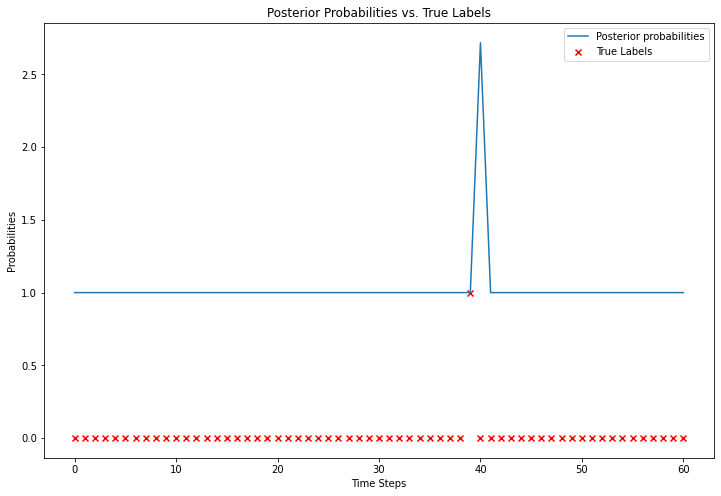

In [35]:
def plot_posteriors(outputs, targets, idx):
    """
    Plot the posterior probabilities for each phoneme class for a single example.
    
    Args:
    outputs (torch.Tensor): The output from the model, typically log probabilities.
    targets (torch.Tensor): The actual targets (labels).
    idx (int): Index of the utterance to plot.
    """
    # Convert outputs to probabilities
    probabilities = torch.exp(outputs[idx])  # Assuming output is log_softmax
    plt.figure(figsize=(12, 8))
    plt.plot(probabilities.cpu().numpy(), label='Posterior probabilities')
    plt.scatter([i for i in range(len(probabilities))], targets[idx].cpu().numpy(), color='red', label='True Labels', marker='x')  # Assuming target is one-hot or indices
    plt.title('Posterior Probabilities vs. True Labels')
    plt.xlabel('Time Steps')
    plt.ylabel('Probabilities')
    plt.legend()
    plt.show()

# Example usage: plot for the first test example
plot_posteriors(outputs, targets, 0)


### 3.

In [36]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

def frame_by_frame_accuracy(outputs, targets):
    """
    Compute the frame-by-frame accuracy for state and phoneme levels.
    
    Args:
    outputs (torch.Tensor): Logits from the model.
    targets (torch.Tensor): True labels.

    Returns:
    float: Accuracy at the state level.
    """
    # Assuming outputs are raw logits, apply softmax to convert to probabilities
    predicted_states = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
    correct = (predicted_states == targets).float().sum()
    total = targets.shape[0]
    accuracy = correct / total
    return accuracy.item()

# Example of usage
accuracy = frame_by_frame_accuracy(outputs, targets)
print(f"Frame-by-frame accuracy at state level: {accuracy * 100:.2f}%")


RuntimeError: The size of tensor a (1526682) must match the size of tensor b (61) at non-singleton dimension 1

In [55]:
def compute_confusion_matrix(outputs, targets, num_classes):
    """
    Compute confusion matrix for evaluating classification performance.
    
    Args:
    outputs (torch.Tensor): Model outputs, assumed to be logits.
    targets (torch.Tensor): Ground truth labels.
    num_classes (int): Number of classes.

    Returns:
    np.ndarray: A confusion matrix.
    """
    preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
    conf_matrix = confusion_matrix(targets.cpu().numpy(), preds.cpu().numpy(), labels=list(range(num_classes)))
    return conf_matrix

# Example of usage
conf_matrix = compute_confusion_matrix(outputs, targets, 91)
print("Confusion Matrix:\n", conf_matrix)


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [53]:
from Levenshtein import distance as levenshtein_distance

def edit_distance_evaluation(outputs, targets):
    """
    Compute the edit distance at the state level for evaluating classification performance.
    
    Args:
    outputs (torch.Tensor): Model outputs, assumed to be logits.
    targets (torch.Tensor): Ground truth labels.

    Returns:
    float: Normalized edit distance, representing the Phone Error Rate (PER).
    """
    predicted_states = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
    predicted_sequence = predicted_states.cpu().numpy().tolist()
    target_sequence = targets.cpu().numpy().tolist()

    # Convert state sequences to string format for edit distance calculation
    predicted_str = ''.join(map(str, predicted_sequence))
    target_str = ''.join(map(str, target_sequence))

    # Calculate edit distance
    edit_dist = levenshtein_distance(predicted_str, target_str)
    per = edit_dist / len(target_sequence)
    return per

# Example of usage
per = edit_distance_evaluation(outputs, targets)
print(f"Phone Error Rate (PER): {per:.2f}")


ModuleNotFoundError: No module named 'Levenshtein'